### Modelo de Bosque Aleatorio con SparkML y Python

Los bosques aleatorios combinan muchos árboles de decisión para reducir el riesgo de sobreajuste. SparkML admite bosques aleatorios para la clasificación binaria, multiclase y para la regresión.
Para predecir el costo de viaje en taxi, se construirá un modelo de regresión.

In [1]:
# medir tiempos
%load_ext autotime

time: 0 ns (started: 2021-06-14 12:19:48 -05:00)


In [2]:
import findspark
#findspark.init("/usr/local/spark/spark-3.1.1-bin-hadoop2.7")  #para linux
findspark.init()                                               #para windows

time: 0 ns (started: 2021-06-14 12:19:49 -05:00)


In [3]:
from pyspark import SparkConf, SparkContext
# Variable de configuración
conf = SparkConf().setMaster("local[*]").setAppName("RandomForestRegressor")  \
    .set("spark.driver.maxResultSize","0") \
    .set("spark.driver.memory", "8g") \
    .set("spark.cores.max", "8")
    #.set("spark.executor.memory", "1g") \
    
# iniciamos un contexto spark (solo se ejecuta uno. Para ejecutar otra vez , reiniciar el kernel)
sc = SparkContext(conf = conf)
sc

<SparkContext master=local[*] appName=RandomForestRegressor>

time: 4.73 s (started: 2021-06-14 12:19:49 -05:00)


### Cargando el conjunto de datos

In [4]:
from pyspark.sql.types import StringType
from pyspark import SQLContext
# le pasamos el contexto anterior
sqlContext = SQLContext(sc)
import os
# path="file:"+os.getcwd()+"/Output"           # para linux
path=os.getcwd()+"/Output"                     # para windows
dfspark = sqlContext.read.format('csv').option("header","true").option("inferSchema","true").load(path+'/*.csv')

time: 9.84 s (started: 2021-06-14 12:19:57 -05:00)


In [5]:
dfspark.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- dif_latitude: double (nullable = true)
 |-- dif_longitude: double (nullable = true)
 |-- distancia: double (nullable = true)
 |-- dia_semana: integer (nullable = true)
 |-- hora: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- anio: integer (nullable = true)

time: 16 ms (started: 2021-06-14 12:20:07 -05:00)


La característica pickup_datetime ya se usó para crear nuevos datos, por lo que procederemos a eliminarla antes de construir el modelo de regresión.

In [6]:
dfspark = dfspark.drop('pickup_datetime')

time: 16 ms (started: 2021-06-14 12:20:12 -05:00)


In [7]:
# Tomando una muestra del 5% del total
# dfspark = dfspark.sample(fraction = 0.05, withReplacement = False, seed=0)

time: 0 ns (started: 2021-06-14 12:20:13 -05:00)


La clase Random Forest de Spark ML requiere que las características estén formateadas como un solo vector.
Usaremos VectorAsembler para poder trabajar con una sola columna que incluya las caracteristicas fundamentales.

In [8]:
from pyspark.ml.feature import VectorAssembler
feature_list = []
ignore=['fare_amount',
       'dif_latitude',
       'dif_longitude']
for col in dfspark.columns:
    if col in ignore:
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

time: 109 ms (started: 2021-06-14 12:20:15 -05:00)


Las únicas entradas para el modelo de bosque aleatorio son la etiqueta (costo del viaje) y el vector características.

In [9]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="fare_amount", featuresCol="features",seed=0)

time: 47 ms (started: 2021-06-14 12:20:16 -05:00)


División del trabajo en 2 etapas

In [10]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

time: 0 ns (started: 2021-06-14 12:20:17 -05:00)


Predefiniendo valores para los parámetros a probar cuando ejecutamos el modelo.
El modelo se reevalúa iterativamente mediante validación cruzada para cada combinación (9) de valores de parámetros.
Los parámetros no especificados usarán la configuración predeterminada de Spark .

In [11]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 25, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 10, num = 3)]) \
    .build()

time: 0 ns (started: 2021-06-14 12:20:18 -05:00)


Usaremos validación cruzada para dividor aleatoriamente la muestra original en tres submuestras, entrenamiento y validación, de esta manera probaremos los parámetros que acabamos de definir.

In [12]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="fare_amount"),
                          numFolds=3)

time: 15 ms (started: 2021-06-14 12:20:19 -05:00)


División de los datos usando randomSplit. El 20% del conjunto de datos para pruebas y el 80% restante para entrenamiento.

In [13]:
(trainingData, testData) = dfspark.randomSplit([0.8, 0.2],seed=0)

time: 32 ms (started: 2021-06-14 12:20:27 -05:00)


El modelo se ajusta utilizando el CrossValidator que creamos. Esto hace que Spark evalúe las características y "haga crecer" numerosos árboles de decisión utilizando muestras aleatorias de los datos de entrenamiento.

In [14]:
cvModel = crossval.fit(trainingData)

time: 7min 38s (started: 2021-06-14 12:20:30 -05:00)


In [15]:
predictions = cvModel.transform(testData)

time: 125 ms (started: 2021-06-14 12:28:08 -05:00)


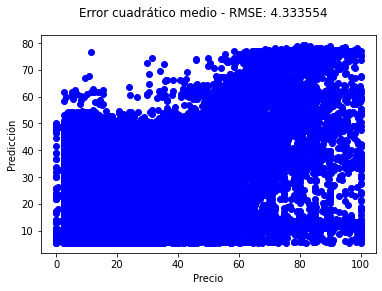

time: 1min 21s (started: 2021-06-14 12:28:08 -05:00)


In [16]:
import matplotlib.pyplot as plt
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(dfspark)
rfResult = rfPred.toPandas()
plt.plot(rfResult.fare_amount, rfResult.prediction, 'bo')
plt.xlabel('Precio')
plt.ylabel('Predicción')
plt.suptitle("Error cuadrático medio - RMSE: %f" % rmse)
plt.show()

Importancia de las características a la hora de evaluar el modelo.

Text(0.5, 1.0, 'Importancia de las características')

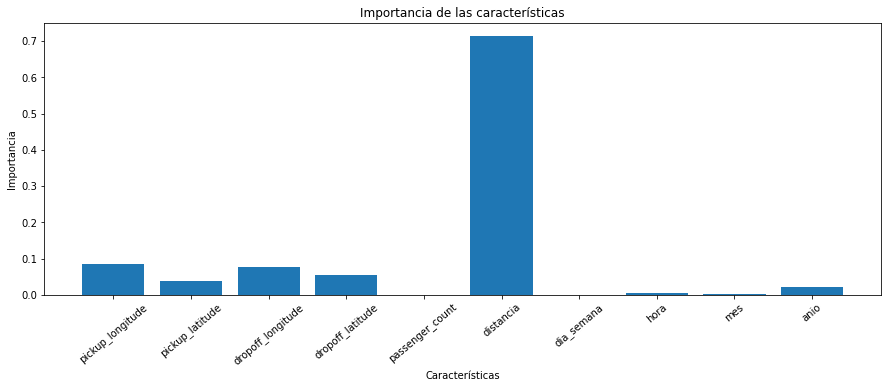

time: 235 ms (started: 2021-06-14 12:47:08 -05:00)


In [31]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.figure(figsize=(15, 5))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importancia')
plt.xlabel('Características')
plt.title('Importancia de las características')

In [32]:
print('Número de árboles- ', bestModel.getNumTrees)
print('Profundidad máxima - ', bestModel.getOrDefault('maxDepth'))

Número de árboles-  17
Profundidad máxima -  10
time: 0 ns (started: 2021-06-14 12:47:13 -05:00)


In [33]:
path=os.getcwd()+"/RFR-rmse-4.33/"
rf.save(path+"RandomForestRegressor")
crossval.save(path+"CrossValidator")
cvModel.save(path+"Model")
evaluator.save(path+"Evaluator")

time: 6.61 s (started: 2021-06-14 12:51:52 -05:00)
